In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-score/credit_score.csv


Missing values:
CUST_ID                0
INCOME                 0
SAVINGS                0
DEBT                   0
R_SAVINGS_INCOME       0
                      ..
CAT_MORTGAGE           0
CAT_SAVINGS_ACCOUNT    0
CAT_DEPENDENTS         0
CREDIT_SCORE           0
DEFAULT                0
Length: 87, dtype: int64


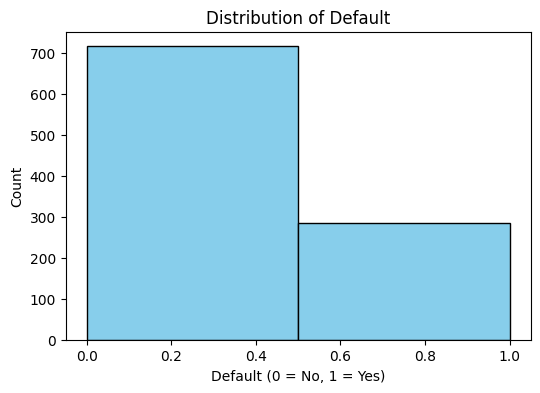

Accuracy: 0.64
Confusion Matrix:
 [[98 48]
 [25 29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73       146
           1       0.38      0.54      0.44        54

    accuracy                           0.64       200
   macro avg       0.59      0.60      0.59       200
weighted avg       0.68      0.64      0.65       200

ROC AUC Score: 0.66


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

data = pd.read_csv('/kaggle/input/credit-score/credit_score.csv')

num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

cat_cols = data.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

print("Missing values:")
print(data.isnull().sum())

plt.figure(figsize=(6, 4))
plt.hist(data['DEFAULT'], bins=2, color='skyblue', edgecolor='black')
plt.title('Distribution of Default')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

X = data.drop(['CUST_ID', 'DEFAULT'], axis=1)
y = data['DEFAULT']

cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(preprocessor.fit_transform(X_train), y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_resampled, y_train_resampled)

X_test_transformed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_transformed)
y_pred_proba = model.predict_proba(X_test_transformed)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc:.2f}")
